In [1]:
import sys ,os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf #只是用来加载mnist数据集
from PIL import Image
import pandas as pd 
import math

/home/danyang/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/danyang/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/danyang/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/danyang/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
def one_hot_label(y):
    one_hot_label = np.zeros((y.shape[0],10))
    y = y.reshape(y.shape[0])
    one_hot_label[range(y.shape[0]),y] = 1
    return one_hot_label

In [3]:
# #（训练图像，训练标签），（测试图像，测试标签）
# # mnist的图像均为28*28尺寸的数据，通道为1
(x_train_origin,t_train_origin),(x_test_origin,t_test_origin) = tf.keras.datasets.mnist.load_data()
X_train = x_train_origin/255.0
X_test = x_test_origin/255.0
m,h,w = x_train_origin.shape
X_train = X_train.reshape((m,1,h,w))
y_train = one_hot_label(t_train_origin)

m,h,w = x_test_origin.shape
X_test = X_test.reshape((m,1,h,w))
y_test = one_hot_label(t_test_origin)
print("shape of x_train is :"+repr(X_train.shape))
print("shape of t_train is :"+repr(y_train.shape))
print("shape of x_test is :"+repr(X_test.shape))
print("shape of t_test is :"+repr(y_test.shape))

11493376/11490434 [==============================] - 1s 0us/step
shape of x_train is :(60000, 1, 28, 28)
shape of t_train is :(60000, 10)
shape of x_test is :(10000, 1, 28, 28)
shape of t_test is :(10000, 10)


y is:5


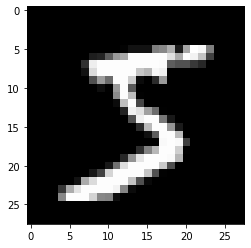

In [4]:
index = 0
plt.imshow(X_train[index].reshape((28,28)),cmap = plt.cm.gray)
print("y is:"+str(np.argmax(y_train[index])))

In [106]:
def im2col2(input_data,fh,fw,stride=1,pad=0):
    '''
     Arguments:
     
     input_data--输入数据，shape为(Number of example,Channel,Height,Width)
     fh -- 滤波器的height
     fw --滤波器的width
     stride -- 步幅
     pad -- 填充
     
     Returns :
     col -- 输入数据根据滤波器、步幅等展开的二维数组，每一行代表一条卷积数据
    '''
    N,C,H,W = input_data.shape
    
    out_h = (H + 2*pad - fh)//stride+1
    out_w = (W+2*pad-fw)//stride+1
#     print(input_data)
    img = np.pad(input_data,[(0,0),(0,0),(pad,pad),(pad,pad)],"constant")
#     print('img',img)
    col = np.zeros((N,out_h,out_w,fh*fw*C))
    
    #将所有维度上需要卷积的值展开成一列
    for y in range(out_h):
        y_start = y * stride
        y_end =  y_start + fh
        for x in range(out_w):
            x_start = x*stride
            x_end = x_start+fw
            col[:,y,x] = img[:,:,y_start:y_end,x_start:x_end].reshape(N,-1)
    col = col.reshape(N*out_h*out_w,-1)
    return col

In [108]:
a = np.random.randint(0,5,size=(1,1,3,3))
print(a)

c = im2col2(a,2,2,1,0)
print(c)
d = col2im2(c,out_shape=(1,1,3,3),fh=2,fw=2,stride=1)
print(d)

[[[[1 1 1]
   [3 2 2]
   [3 4 3]]]]
[[1. 1. 3. 2.]
 [1. 1. 2. 2.]
 [3. 2. 3. 4.]
 [2. 2. 4. 3.]]
[[[[1. 1. 1.]
   [3. 2. 2.]
   [3. 4. 3.]]]]


In [17]:
def col2im2(col,out_shape,fh,fw,stride=1,pad=0):
    '''
     Arguments:
     col: 二维数组     
     out_shape-- 输出的shape，shape为(Number of example,Channel,Height,Width)
     fh -- 滤波器的height
     fw --滤波器的width
     stride -- 步幅
     pad -- 填充
     
     Returns :
     img -- 将col转换成的img ，shape为out_shape
    '''
    N,C,H,W = out_shape
    
    col_m,col_n = col.shape
    
    out_h = (H + 2*pad - fh)//stride+1
    out_w = (W+2*pad-fw)//stride+1

    

    img = np.zeros((N, C, H , W))
   # img = np.pad(img,[(0,0),(0,0),(pad,pad),(pad,pad)],"constant")

    #将col转换成一个filter
    for c in range(C):
        for y in range(out_h):
            for x in range(out_w):
                col_index = (c*out_h*out_w)+y*out_w+x
                ih = y*stride
                iw =  x*stride
                img[:,c,ih:ih+fh,iw:iw+fw] = col[col_index].reshape((fh,fw))
    return img

In [38]:
def im2col2test():
    a = np.random.randint(0,5,size=(2,3,4,4))
    c = im2col2(a,2,2,2,1)

    a = np.random.randint(0,5,size=(1,1,3,3))
    print(a)
    
    c = im2col2(a,2,2,1,0)
    print(c)
    d = col2im2(c,out_shape=(1,1,3,3),fh=2,fw=2,stride=1)
    print(d)

In [39]:
im2col2test()

[[[[2 1 3]
   [4 4 2]
   [2 1 4]]]]
[[2. 1. 4. 4.]
 [1. 3. 4. 2.]
 [4. 4. 2. 1.]
 [4. 2. 1. 4.]]
[[[[2. 1. 3.]
   [4. 4. 2.]
   [2. 1. 4.]]]]


In [22]:
a = np.random.randint(0,5,size=(2,3,4,4))
a

array([[[[1, 4, 0, 2],
         [4, 0, 0, 1],
         [3, 4, 4, 2],
         [4, 4, 0, 0]],

        [[1, 0, 1, 0],
         [4, 0, 4, 4],
         [4, 4, 4, 4],
         [2, 2, 0, 4]],

        [[3, 2, 0, 2],
         [3, 1, 3, 0],
         [4, 3, 0, 1],
         [2, 1, 3, 4]]],


       [[[1, 0, 1, 2],
         [2, 3, 1, 3],
         [3, 4, 0, 3],
         [4, 3, 4, 1]],

        [[1, 2, 4, 4],
         [2, 4, 0, 2],
         [3, 0, 0, 2],
         [1, 0, 4, 2]],

        [[1, 2, 0, 0],
         [3, 3, 3, 4],
         [2, 2, 4, 2],
         [2, 0, 1, 4]]]])

In [28]:
c = im2col2(a,2,2,1,0)
c

array([[1., 4., 4., 0., 1., 0., 4., 0., 3., 2., 3., 1.],
       [4., 0., 0., 0., 0., 1., 0., 4., 2., 0., 1., 3.],
       [0., 2., 0., 1., 1., 0., 4., 4., 0., 2., 3., 0.],
       [4., 0., 3., 4., 4., 0., 4., 4., 3., 1., 4., 3.],
       [0., 0., 4., 4., 0., 4., 4., 4., 1., 3., 3., 0.],
       [0., 1., 4., 2., 4., 4., 4., 4., 3., 0., 0., 1.],
       [3., 4., 4., 4., 4., 4., 2., 2., 4., 3., 2., 1.],
       [4., 4., 4., 0., 4., 4., 2., 0., 3., 0., 1., 3.],
       [4., 2., 0., 0., 4., 4., 0., 4., 0., 1., 3., 4.],
       [1., 0., 2., 3., 1., 2., 2., 4., 1., 2., 3., 3.],
       [0., 1., 3., 1., 2., 4., 4., 0., 2., 0., 3., 3.],
       [1., 2., 1., 3., 4., 4., 0., 2., 0., 0., 3., 4.],
       [2., 3., 3., 4., 2., 4., 3., 0., 3., 3., 2., 2.],
       [3., 1., 4., 0., 4., 0., 0., 0., 3., 3., 2., 4.],
       [1., 3., 0., 3., 0., 2., 0., 2., 3., 4., 4., 2.],
       [3., 4., 4., 3., 3., 0., 1., 0., 2., 2., 2., 0.],
       [4., 0., 3., 4., 0., 0., 0., 4., 2., 4., 0., 1.],
       [0., 3., 4., 1., 0., 2.,

In [29]:
d = col2im2(c,out_shape=(2,3,4,4),fh=2,fw=2,stride=1)
d

ValueError: cannot reshape array of size 12 into shape (2,2)

In [5]:
def relu(input_X):
    A = np.where(input_X < 0, 0, input_X)
    return A

In [6]:
def softmax(input_X):
    exp_a = np.exp(input_X)
    sum_exp_a = np.sum(exp_a, axis=1)
    sum_exp_a = sum_exp_a.reshape(input_X.shape[0],-1)
    ret = exp_a/sum_exp_a
    return ret

In [7]:
def cross_entropy_error(labels, logits):
    return -np.sum(labels*np.log(logits))

In [139]:
class Convolution:
    def __init__(self, W, fb, stride = 1, pad = 0):
        """
        W-- 滤波器权重，shape为(FN,NC,FH,FW),FN 为滤波器的个数
        fb -- 滤波器的偏置，shape 为(1,FN) 
        stride -- 步长
        pad -- 填充个数
        """
        self.W = W
        self.fb = fb
        self.stride = stride
        self.pad = pad
        
        self.col_X = None
        self.X = None
        self.col_W = None
        
        self.dW = None
        self.db = None
        self.out_shape = None
        
    def forward(self, input_X):
        """
        input_X-- shape为(m,nc,height,width)
        """  
        self.X = input_X
        FN, NC, FH, FW = self.W.shape
        m, input_nc, input_h, input_w = self.X.shape

        out_h = int((input_h + 2*self.pad - FH)/self.stride + 1)
        out_w = int((input_w + 2*self.pad - FW)/self.stride + 1)
#         print('===================Convolution======================')
#         print("input_X",input_X)
#         print(input_X.shape)
        #将输入数据展开成二维数组，shape为（m*out_h*out_w,FH*FW*C)
        self.col_X = col_X = im2col2(self.X,FH,FW,self.stride,self.pad)
#         print("self.col_X",self.col_X)
#         print(self.col_X.shape)
        #将滤波器一个个按列展开(FH*FW*C,FN)
        self.col_W = col_W = self.W.reshape(FN,-1).T
#         print('self.col_W',self.col_W)
#         print(self.col_W.shape)
        out = np.dot(col_X,col_W)+self.fb
#         print('out',out)
#         print(out.shape)
        out = out.T
#         print(out.shape)
        out = out.reshape(m,FN,out_h,out_w)
#         print(out.shape)

        self.out_shape = out.shape
        return out
    
    def backward(self, dz, learning_rate):
#         print('dz',dz)
        print(dz.shape)
        assert(dz.shape == self.out_shape)
        
        FN, NC, FH, FW = self.W.shape
        o_FN,o_NC,o_FH,o_FW = self.out_shape
        
        col_dz = dz.reshape(o_NC, -1)
        col_dz = col_dz.T
        print('col_dz',col_dz.shape)
        print('self.col_X',self.col_X.shape)
        self.dW = np.dot(self.col_X.T,col_dz)  #shape is (FH*FW*C,FN)
        self.db = np.sum(col_dz,axis=0,keepdims=True)

        self.dW = self.dW.T.reshape(self.W.shape)
        self.db = self.db.reshape(self.fb.shape)
        
        d_col_x = np.dot(col_dz,self.col_W.T) #shape is (m*out_h*out_w,FH,FW*C)
        print('d_col_x',d_col_x.shape)
        dx = col2im2(d_col_x,self.X.shape,FH,FW,stride=1)
        print('dx',dx.shape)
        
        assert(dx.shape == self.X.shape)
        #更新W和b
        self.W = self.W - learning_rate*self.dW
        self.fb = self.fb -learning_rate*self.db
        
        return dx

In [140]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad 
        self.X = None
        self.arg_max = None
        
    def forward (self, input_X):
        """
        前向传播
        input_X-- shape为(m,nc,height,width)
        """ 
        self.X = input_X
        N , C, H, W = input_X.shape
        out_h = int(1+(H-self.pool_h)/self.stride)
        out_w = int(1+(W-self.pool_w)/self.stride)
        #展开
#         print('input_X',input_X.shape)
        col = im2col2(input_X,self.pool_h,self.pool_w,self.stride,self.pad)
#         print('col',col.shape)
        col = col.reshape(-1,self.pool_h*self.pool_w)
#         print('col',col.shape)

        arg_max = np.argmax(col,axis=1)
#         print('arg_max',arg_max.shape)
        #最大值
        out = np.max(col,axis=1)
#         print('out',out.shape)
        out =out.T.reshape(N,C,out_h,out_w)
#         print('out',out.shape)
        self.arg_max = arg_max
        return out
        
    def backward(self ,dz):
        """
        反向传播
        Arguments:
        dz-- out的导数，shape与out 一致
        
        Return:
        返回前向传播是的input_X的导数
        """ 
        pool_size = self.pool_h*self.pool_w
        dmax = np.zeros((dz.size,pool_size))
        dmax[np.arange(self.arg_max.size),self.arg_max.flatten()] = dz.flatten()
        
        dx = col2im2(dmax,out_shape=self.X.shape,fh=self.pool_h,fw=self.pool_w,stride=self.stride)
        return dx

In [141]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self ,X):
        self.mask = X <= 0
        out = X
        out[self.mask] = 0
        return out
    
    def backward(self,dz):
        dz[self.mask] = 0
        dx = dz 
        return dx

In [142]:
class SoftMax:
    def __init__ (self):
        self.y_hat = None
        
    def forward(self,X):
        
        self.y_hat = softmax(X)
        return self.y_hat
    
    def backward(self,labels):
        m = labels.shape[0]
        dx = (self.y_hat - labels)
        return dx

In [143]:
def compute_cost(logits,label):
    return cross_entropy_error(label,logits)

In [144]:
class Affine:
    def __init__(self,W,b):
        self.W = W # shape is (n_x,n_unit)
        self.b  = b  # shape is(1,n_unit)
        self.X = None
        self.origin_x_shape = None
        
        self.dW = None
        self.db = None
        
        self.out_shape =None
    def forward(self,X):
        self.origin_x_shape = X.shape 
        self.X = X.reshape(X.shape[0],-1)#(m,n)
        out =  np.dot(self.X, self.W)+self.b
        self.out_shape = out.shape
        return out
    
    def backward(self,dz,learning_rate):
        """
        dz-- 前面的导数
        """  
#         print("Affine backward")
#         print(self.X.shape)
#         print(dz.shape)
#         print(self.W.shape)
    
        assert(dz.shape == self.out_shape)
        
        m = self.X.shape[0]
        
        self.dW = np.dot(self.X.T,dz)/m
        self.db = np.sum(dz,axis=0,keepdims=True)/m
        
        assert(self.dW.shape == self.W.shape)
        assert(self.db.shape == self.b.shape)
        
        dx = np.dot(dz,self.W.T)
        assert(dx.shape == self.X.shape)
        
        dx = dx.reshape(self.origin_x_shape) # 保持与之前的x一样的shape
        
        #更新W和b
        self.W = self.W-learning_rate*self.dW
        self.b = self.b - learning_rate*self.db
        
        return dx

In [145]:
class SimpleConvNet:

    def __init__(self):
        self.X = None
        self.Y= None
        self.layers = []

    def add_conv_layer(self,n_filter,n_c , f, stride=1, pad=0):
        """
        添加一层卷积层
        Arguments:
        n_c -- 输入数据通道数，也即卷积层的通道数
        n_filter -- 滤波器的个数
        f --滤波器的长/宽

        Return :
        Conv -- 卷积层
        """

        # 初始化W，b
        W = np.random.randn(n_filter, n_c, f, f)*0.01
        fb = np.zeros((1, n_filter))
        # 卷积层
        Conv = Convolution(W, fb, stride=stride, pad=pad)
        return Conv

    def add_maxpool_layer(self, pool_shape, stride=1, pad=0):
        """
        添加一层池化层
        Arguments:
        pool_shape -- 滤波器的shape
        f -- 滤波器大小
        Return :
         Pool -- 初始化的Pool类
        """
        pool_h, pool_w = pool_shape
        pool = Pooling(pool_h, pool_w, stride=stride, pad=pad)
        
        return pool
    
    def add_affine(self,n_x, n_units):
        """
        添加一层全连接层
        Arguments:
        n_x -- 输入个数
        n_units -- 神经元个数
        Return :
        fc_layer -- Affine层对象
        """
        
        W= np.random.randn(n_x, n_units)*0.01
        
        b = np.zeros((1, n_units))
        
        fc_layer = Affine(W,b)
        
        return fc_layer
    
    def add_relu(self):
        relu_layer =  Relu()
        return relu_layer
    
    
    def add_softmax(self):
        softmax_layer = SoftMax()
        return softmax_layer
    
    #计算卷积或池化后的H和W
    def cacl_out_hw(self,HW,f,stride = 1,pad = 0):
        return (HW+2*pad - f)/stride+1
    

    
    
    def init_model(self,train_X,n_classes):
        """
        初始化一个卷积层网络
        """
        N,C,H,W = train_X.shape
        #卷积层
        n_filter = 4
        f = 7
        
        conv_layer = self.add_conv_layer(n_filter= n_filter,n_c=C,f=f,stride=1)
        
        out_h = self.cacl_out_hw(H,f)
        out_w = self.cacl_out_hw(W,f)
        out_ch = n_filter
        
        self.layers.append(conv_layer)
        
        #Relu
        relu_layer = self.add_relu()
        self.layers.append(relu_layer)
        
        #池化
        f = 2
        pool_layer = self.add_maxpool_layer(pool_shape=(f,f),stride=2)
        out_h = self.cacl_out_hw(out_h,f,stride=2)
        out_w = self.cacl_out_hw(out_w,f,stride=2)
        #out_ch 不改变
        self.layers.append(pool_layer)
        

        
        
        #Affine层
        n_x = int(out_h*out_w*out_ch)
        n_units = 32
        fc_layer = self.add_affine(n_x=n_x,n_units=n_units)
        self.layers.append(fc_layer)
        
        #Relu
        relu_layer = self.add_relu()
        self.layers.append(relu_layer)
        
        #Affine
        fc_layer = self.add_affine(n_x=n_units,n_units=n_classes)
        self.layers.append(fc_layer)
        
        #SoftMax
        softmax_layer = self.add_softmax()
        self.layers.append(softmax_layer)
        
        
        
    def forward_progation(self,train_X, print_out = False):
        """
        前向传播
        Arguments:
        train_X -- 训练数据
        f -- 滤波器大小

        Return :
         Z-- 前向传播的结果
         loss -- 损失值
        """
    
        
        N,C,H,W = train_X.shape
        index = 0
        # 卷积层
        conv_layer = self.layers[index]
        X = conv_layer.forward(train_X)
        index =index+1
        if print_out:
            print("卷积之后："+str(X.shape))
        # Relu
        relu_layer =  self.layers[index]
        index =index+1
        X = relu_layer.forward(X)
        if print_out:
            print("Relu："+str(X.shape))
            
        
        # 池化层
        pool_layer = self.layers[index]
        index =index+1
        X = pool_layer.forward(X)
        if print_out:
            print("池化："+str(X.shape))


        #Affine层
        fc_layer = self.layers[index]
        index =index+1
        X = fc_layer.forward(X)
        if print_out:
            print("Affline 层的X："+str(X.shape))

        #Relu
        relu_layer = self.layers[index]
        index =index+1
        X = relu_layer.forward(X)
        if print_out:
            print("Relu 层的X："+str(X.shape))
        
        #Affine层
        fc_layer = self.layers[index]
        index =index+1
        X = fc_layer.forward(X)
        if print_out:
            print("Affline 层的X："+str(X.shape))

        #SoftMax层
        sofmax_layer = self.layers[index]
        index =index+1
        A = sofmax_layer.forward(X)
        if print_out:
            print("Softmax 层的X："+str(A.shape))
            
        return A
        
    def back_progation(self,train_y,learning_rate):
        """
        反向传播
        Arguments:
   
        """
        index = len(self.layers)-1
        sofmax_layer = self.layers[index]
        index -= 1
        dz = sofmax_layer.backward(train_y)
        
        fc_layer = self.layers[index]
        dz = fc_layer.backward(dz,learning_rate=learning_rate)
        index -= 1
        
        relu_layer = self.layers[index]
        dz = relu_layer.backward(dz)
        index -= 1
        
        fc_layer = self.layers[index]
        dz = fc_layer.backward(dz,learning_rate=learning_rate)
        index -= 1
        
        pool_layer = self.layers[index]
        dz = pool_layer.backward(dz)
        index -= 1
        
        relu_layer =  self.layers[index]
        dz = relu_layer.backward(dz)
        index -= 1
        
        conv_layer = self.layers[index]
        conv_layer.backward(dz,learning_rate=learning_rate)
        index -= 1
        
      
    def get_minibatch(self,batch_data,minibatch_size,num):
        m_examples = batch_data.shape[0]
        minibatches = math.ceil( m_examples / minibatch_size)
 
        if(num < minibatches):
            return batch_data[num*minibatch_size:(num+1)*minibatch_size]
        else:
            return batch_data[num*minibatch_size:m_examples]
    
    
    def optimize(self,train_X, train_y,minibatch_size,learning_rate=0.05,num_iters=500):
        """
        优化方法
        Arguments:
        train_X -- 训练数据 
        train_y -- 训练数据的标签
        learning_rate -- 学习率
        num_iters -- 迭代次数
        minibatch_size 
        """
        m = train_X.shape[0]
        num_batches  = math.ceil(m / minibatch_size)
        
        costs = []
        for iteration in range(num_iters):
            iter_cost = 0
            for batch_num in range(num_batches):
                minibatch_X = self.get_minibatch(train_X,minibatch_size,batch_num)
                minibatch_y = self.get_minibatch(train_y,minibatch_size,batch_num)
                
                # 前向传播
                A = self.forward_progation(minibatch_X,print_out=False)
                #损失:
                cost = compute_cost (A,minibatch_y)
                #反向传播
                self.back_progation(minibatch_y,learning_rate)
                if(iteration%100 == 0):
                    iter_cost += cost/num_batches
                    
#             if(iteration%100 == 0):
            print("After %d iters ,cost is :%g" %(iteration,iter_cost))
            costs.append(iter_cost)
            
            
            
            
        #画出损失函数图
        plt.plot(costs)
        plt.xlabel("iterations/hundreds")
        plt.ylabel("costs")
        plt.show()
        
       
    def predicate(self, train_X):
        """
        预测
        """
        logits = self.forward_progation(train_X)
        one_hot = np.zeros_like(logits)
        one_hot[range(train_X.shape[0]),np.argmax(logits,axis=1)] = 1
        return one_hot   

    def fit(self,train_X, train_y):
        """
        训练
        """
        self.X = train_X
        self.Y = train_y
        n_y = train_y.shape[1]
        m = train_X.shape[0]
        
        #初始化模型
        self.init_model(train_X,n_classes=n_y)

        self.optimize(train_X, train_y,minibatch_size=10,learning_rate=0.05,num_iters=1)
        
        logits = self.predicate(train_X)
        
        accuracy = np.sum(np.argmax(logits,axis=1) == np.argmax(train_y,axis=1))/m
        print("训练集的准确率为：%g" %(accuracy))

(10, 4, 22, 22)
col_dz (4840, 4)
self.col_X (4840, 49)
d_col_x (4840, 49)
dx (10, 1, 28, 28)
After 0 iters ,cost is :23.0253


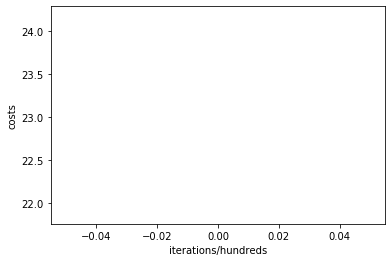

训练集的准确率为：0.3


In [146]:
convNet = SimpleConvNet()
#拿20张先做实验
train_X = X_train[0:10]
train_y = y_train[0:10]
convNet.fit(train_X,train_y)

In [52]:
train_X.shape



(10, 1, 28, 28)

In [53]:
train_y.shape

(10, 10)

In [171]:
from activators import ReluActivator, IdentityActivator

In [148]:
def get_patch(input_array, i, j, filter_width, filter_height, stride):
    '''
    从输入数组中获取本次卷积的区域，
    自动适配输入为2D和3D的情况
    '''
    start_i = i * stride
    start_j = j * stride
    if input_array.ndim == 2:
        input_array_conv = input_array[start_i : start_i + filter_height, start_j : start_j + filter_width]
        return input_array_conv
    elif input_array.ndim == 3:
        input_array_conv = input_array[:,
            start_i : start_i + filter_height,
            start_j : start_j + filter_width]
        return input_array_conv

In [194]:
def get_max_index(array):
    # 获取一个2D区域的最大值所在的索引
    max_i = 0
    max_j = 0
    max_value = array[0, 0]
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i, j] > max_value:
                max_value = array[i,j]
                max_i, max_j = i, j
    return max_i, max_j

In [199]:
def conv(input_array, kernel_array, output_array, stride, bias):
    '''
    计算卷积，自动适配输入为2D和3D的情况
    '''
    channel_number = input_array.ndim
    output_width = output_array.shape[1]
    output_height = output_array.shape[0]
    kernel_width = kernel_array.shape[-1]
    kernel_height = kernel_array.shape[-2]
    for i in range(output_height):
        for j in range(output_width):
            output_array[i][j] = (    
                get_patch(input_array, i, j, kernel_width, 
                    kernel_height, stride) * kernel_array
                ).sum() + bias

In [164]:
def padding(input_array, zp):
    '''
    为数组增加Zero padding，自动适配输入为2D和3D的情况
    '''
    if zp == 0:
        return input_array
    else:
        if input_array.ndim == 3:
            input_width = input_array.shape[2]
            input_height = input_array.shape[1]
            input_depth = input_array.shape[0]
            padded_array = np.zeros((input_depth, input_height +2 * zp, input_width + 2 * zp))
            padded_array[:, zp : zp + input_height, zp : zp + input_width] = input_array
            return padded_array
        elif input_array.ndim == 2:
            input_width = input_array.shape[1]
            input_height = input_array.shape[0]
            padded_array = np.zeros((
                input_height + 2 * zp,
                input_width + 2 * zp))
            padded_array[zp : zp + input_height,
                zp : zp + input_width] = input_array
            return padded_array

In [165]:
def element_wise_op(array, op):
    for i in np.nditer(array, op_flags=['readwrite']):
        i[...] = op(i)

In [166]:
class Filter(object):
    def __init__(self, width, height, depth):
        self.weights = np.random.uniform(-1e-4, 1e-4,(depth, height, width))
        self.bias = 0
        self.weights_grad = np.zeros(self.weights.shape)
        self.bias_grad = 0
    
    def __repr__(self):
        return 'filter weights:\n%s\nbias:\n%s' % (
            repr(self.weights), repr(self.bias))
    
    def get_weights(self):
        return self.weights
    
    def get_bias(self):
        return self.bias
    
    def update(self, learning_rate):
        self.weights -= learning_rate * self.weights_grad
        self.bias -= learning_rate * self.bias_grad

In [258]:
class ConvLayer(object):
    '''
    参数含义：
    input_width:输入图片尺寸——宽度
    input_height:输入图片尺寸——长度
    channel_number:通道数，彩色为3，灰色为1
    filter_width:卷积核的宽
    filter_height:卷积核的长
    filter_number:卷积核数量
    zero_padding：补零长度
    stride:步长
    activator:激活函数
    learning_rate:学习率
    '''
    def __init__(self, input_width, input_height,
                 channel_number, filter_width,
                 filter_height, filter_number,
                 zero_padding, stride, activator,
                 learning_rate):
        self.input_width = input_width
        self.input_height = input_height
        self.channel_number = channel_number
        self.filter_width = filter_width
        self.filter_height = filter_height
        self.filter_number = filter_number
        self.zero_padding = zero_padding
        self.stride = stride
        self.output_width = \
            ConvLayer.calculate_output_size(
            self.input_width, filter_width, zero_padding,
            stride)
        self.output_height = \
            ConvLayer.calculate_output_size(
            self.input_height, filter_height, zero_padding,
            stride)
        self.output_array = np.zeros((self.filter_number,
            self.output_height, self.output_width))
        self.filters = []
        for i in range(filter_number):
            self.filters.append(Filter(filter_width,
                filter_height, self.channel_number))
        self.activator = activator
        self.learning_rate = learning_rate
        
    def calculate_output_size(input_size, filter_size, zero_padding, stride):
        return (input_size + 2*zero_padding - filter_size) // stride + 1
    
    def forward(self, input_array):
        '''
        计算卷积层的输出
        输出结果保存在self.output_array
        '''
        self.input_array = input_array
        self.padded_input_array = padding(input_array,self.zero_padding)
        
        for f in range(self.filter_number):
            filter = self.filters[f]
            conv(self.padded_input_array, filter.get_weights(), self.output_array[f], self.stride, filter.get_bias())
        element_wise_op(self.output_array, 
                        self.activator.forward)
        
    def backward(self, input_array, sensitivity_array, activator):
        '''
        计算传递给前一层的误差项，以及计算每个权重的梯度
        前一层的误差项保存在self.delta_array
        梯度保存在Filter对象的weights_grad
        '''
        self.forward(input_array)
        self.bp_sensitivity_map(sensitivity_array, activator)
        self.bp_gradient(sensitivity_array)
        
    def update(self):
        '''
        按照梯度下降，更新权重
        '''
        for filter in self.filters:
            filter.update(self.learning_rate)

    def bp_sensitivity_map(self, sensitivity_array,
                           activator):
        '''
        计算传递到上一层的sensitivity map
        sensitivity_array: 本层的sensitivity map
        activator: 上一层的激活函数
        '''
        # 处理卷积步长，对原始sensitivity map进行扩展
        expanded_array = self.expand_sensitivity_map(
            sensitivity_array)
        # full卷积，对sensitivitiy map进行zero padding
        # 虽然原始输入的zero padding单元也会获得残差
        # 但这个残差不需要继续向上传递，因此就不计算了
        expanded_width = expanded_array.shape[2]
        zp = (self.input_width +  
              self.filter_width - 1 - expanded_width) // 2
        padded_array = padding(expanded_array, zp)
        print('=======================padded_array========================')
        print(padded_array)
        # 初始化delta_array，用于保存传递到上一层的
        # sensitivity map
        self.delta_array = self.create_delta_array()
        # 对于具有多个filter的卷积层来说，最终传递到上一层的
        # sensitivity map相当于所有的filter的
        # sensitivity map之和
        
        for f in range(self.filter_number):
            #print('f',f)
            filter = self.filters[f]
            # 将filter权重翻转180度
            flipped_weights = np.array(list(map(
                lambda i: np.rot90(i, 2), 
                filter.get_weights())))

#             flipped_weights = self.flip180(filter.get_weights())
            # 计算与一个filter对应的delta_array
            delta_array = self.create_delta_array()
            #print('padded_array[f]',padded_array[f])
            for d in range(delta_array.shape[0]):
                conv(padded_array[f], flipped_weights[d],
                    delta_array[d], 1, 0)
            self.delta_array += delta_array
        # 将计算结果与激活函数的偏导数做element-wise乘法操作
        derivative_array = np.array(self.input_array)
        element_wise_op(derivative_array, 
                        activator.backward)
        self.delta_array *= derivative_array
    
    def bp_gradient(self,sensitivity_array):
        # 处理卷积步长，对原始sensitivity map进行扩展
        expanded_array = self.expand_sensitivity_map(sensitivity_array)
        for f in range(self.filter_number):
            filter = self.filters[f]
            for d in range(filter.weights.shape[0]):
                conv(self.padded_input_array[d], expanded_array[f], filter.weights_grad[d], 1, 0)
            filter.bias_grad = expanded_array[f].sum()
    
    
    def expand_sensitivity_map(self, sensitivity_array):
        depth = sensitivity_array.shape[0]
        # 确定扩展后sensitivity map的大小
        # 计算stride为1时sensitivity map的大小
        expanded_width = (self.input_width - self.filter_width + 2 * self.zero_padding + 1)
        expanded_height = (self.input_height - self.filter_height + 2 * self.zero_padding + 1)
        # 构建新的sensitivity_map
        expand_array = np.zeros((depth, expanded_height, expanded_width))
        # 从原始sensitivity map拷贝误差值
        for i in range(self.output_height):
            for j in range(self.output_width):
                i_pos = i * self.stride
                j_pos = j * self.stride
                expand_array[:,i_pos,j_pos] = \
                    sensitivity_array[:,i,j]
        return expand_array
    
    def create_delta_array(self):
        return np.zeros((self.channel_number, self.input_height, self.input_width))
    

In [259]:
class MaxPoolingLayer(object):
    def __init__(self, input_width, input_height, channel_number, 
                 filter_width, filter_height, stride):
        self.input_width = input_width
        self.input_height = input_height
        self.channel_number = channel_number
        self.filter_width = filter_width
        self.filter_height = filter_height
        self.stride = stride
        
        self.output_width = (input_width - filter_height) // stride + 1
        self.output_height = (input_height - filter_height) // self.stride + 1
        self.output_array = np.zeros((self.channel_number, self.output_height, self.output_width))
    
    def forward(self, input_array):
        for d in range(self.channel_number):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    self.output_array[d,i,j] = (    
                        get_patch(input_array[d], i, j,
                            self.filter_width, 
                            self.filter_height, 
                            self.stride).max())
    
    def backward(self, input_array, sensitivity_array):
        self.delta_array = np.zeros(input_array.shape)
        for d in range(self.channel_number):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    patch_array = get_patch(
                        input_array[d], i, j,
                        self.filter_width, 
                        self.filter_height, 
                        self.stride)
                    k, l = get_max_index(patch_array)
                    self.delta_array[d, 
                        i * self.stride + k, 
                        j * self.stride + l] = \
                        sensitivity_array[d,i,j]

In [260]:
###测试前向传播和反向传播后跟新的filter结果是否正确
def init_test():
    a = np.array(
        [[[0,1,1,0,2],
          [2,2,2,2,1],
          [1,0,0,2,0],
          [0,1,1,0,0],
          [1,2,0,0,2]],
         [[1,0,2,2,0],
          [0,0,0,2,0],
          [1,2,1,2,1],
          [1,0,0,0,0],
          [1,2,1,1,1]],
         [[2,1,2,0,0],
          [1,0,0,1,0],
          [0,2,1,0,1],
          [0,1,2,2,2],
          [2,1,0,0,1]]])
    b = np.array(
        [[[0,1,1],
          [2,2,2],
          [1,0,0]],
         [[1,0,2],
          [0,0,0],
          [1,2,1]]])
    cl = ConvLayer(5,5,3,3,3,2,1,2,IdentityActivator(),0.001)
    cl.filters[0].weights = np.array(
        [[[-1,1,0],
          [0,1,0],
          [0,1,1]],
         [[-1,-1,0],
          [0,0,0],
          [0,-1,0]],
         [[0,0,-1],
          [0,1,0],
          [1,-1,-1]]], dtype=np.float64)
    cl.filters[0].bias=1
    cl.filters[1].weights = np.array(
        [[[1,1,-1],
          [-1,-1,1],
          [0,-1,1]],
         [[0,1,0],
         [-1,0,-1],
          [-1,1,0]],
         [[-1,0,0],
          [-1,0,1],
          [-1,0,0]]], dtype=np.float64)
    return a, b, cl

In [261]:
def test():
    a, b, cl = init_test()
    cl.forward(a)
    print ("前向传播结果:", cl.output_array)
    cl.backward(a, b, IdentityActivator())
    cl.update()
    print ("反向传播后更新得到的filter1:",cl.filters[0])
    print ("反向传播后更新得到的filter2:",cl.filters[1])

In [262]:
test()

前向传播结果: [[[ 6.  7.  5.]
  [ 3. -1. -1.]
  [ 2. -1.  4.]]

 [[ 2. -5. -8.]
  [ 1. -4. -4.]
  [ 0. -5. -5.]]]
=======================padded_array======================== [[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 2. 0. 2. 0. 2. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 2. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 2. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0.]]]
反向传播后更新得到的filter1: filter weights:
array([[[-1.008,  0.99 , -0.009],
        [-0.005,  0.994, -0.006],
        [-0.006,  0.995,  0.996]],

       [[-1.004, -1.001, -0.004],
        [-0.01 , -0.009, -0.012],
        [-0.002, -1.002, -0.002]],

       [[-0.002, -0.002, -1.003],
        [-0.005,  0.992, -0.005],
        [ 0.993, -1.008, -1.007]]])
bias:
0.991
反向传播后更新得到的filter2: filter weights:
array([[[ 9.980e-01,  9.980e-01, -1.001e+00],
        [-1.004e+00, -1.007e+00,  9.97

In [176]:
init_test()

(array([[[0, 1, 1, 0, 2],
         [2, 2, 2, 2, 1],
         [1, 0, 0, 2, 0],
         [0, 1, 1, 0, 0],
         [1, 2, 0, 0, 2]],
 
        [[1, 0, 2, 2, 0],
         [0, 0, 0, 2, 0],
         [1, 2, 1, 2, 1],
         [1, 0, 0, 0, 0],
         [1, 2, 1, 1, 1]],
 
        [[2, 1, 2, 0, 0],
         [1, 0, 0, 1, 0],
         [0, 2, 1, 0, 1],
         [0, 1, 2, 2, 2],
         [2, 1, 0, 0, 1]]]), array([[[0, 1, 1],
         [2, 2, 2],
         [1, 0, 0]],
 
        [[1, 0, 2],
         [0, 0, 0],
         [1, 2, 1]]]), <__main__.ConvLayer at 0x7f044a6095f8>)

In [191]:
def init_pool_test():
    a = np.array(
        [[[1,1,2,4],
          [5,6,7,8],
          [3,2,1,0],
          [1,2,3,4]],
         [[0,1,2,3],
          [4,5,6,7],
          [8,9,0,1],
          [3,4,5,6]]], dtype=np.float64)

    b = np.array(
        [[[1,2],
          [2,4]],
         [[3,5],
          [8,2]]], dtype=np.float64)

    mpl = MaxPoolingLayer(4,4,2,2,2,2)
    return a, b, mpl

In [195]:
def test_pool():
    a, b, mpl = init_pool_test()
    mpl.forward(a)
    print ('input array:\n%s\noutput array:\n%s' % (a, mpl.output_array))
    mpl.backward(a, b)
    print ('input array:\n%s\nsensitivity array:\n%s\ndelta array:\n%s' % (a, b, mpl.delta_array))

In [196]:
test_pool()

input array:
[[[1. 1. 2. 4.]
  [5. 6. 7. 8.]
  [3. 2. 1. 0.]
  [1. 2. 3. 4.]]

 [[0. 1. 2. 3.]
  [4. 5. 6. 7.]
  [8. 9. 0. 1.]
  [3. 4. 5. 6.]]]
output array:
[[[6. 8.]
  [3. 4.]]

 [[5. 7.]
  [9. 6.]]]
input array:
[[[1. 1. 2. 4.]
  [5. 6. 7. 8.]
  [3. 2. 1. 0.]
  [1. 2. 3. 4.]]

 [[0. 1. 2. 3.]
  [4. 5. 6. 7.]
  [8. 9. 0. 1.]
  [3. 4. 5. 6.]]]
sensitivity array:
[[[1. 2.]
  [2. 4.]]

 [[3. 5.]
  [8. 2.]]]
delta array:
[[[0. 0. 0. 0.]
  [0. 1. 0. 2.]
  [2. 0. 0. 0.]
  [0. 0. 0. 4.]]

 [[0. 0. 0. 0.]
  [0. 3. 0. 5.]
  [0. 8. 0. 0.]
  [0. 0. 0. 2.]]]


In [ ]:
def gradient_check():
    '''
    梯度检查
    '''
    # 设计一个误差函数，取所有节点输出项之和
    error_function = lambda o: o.sum()
    
    # 计算forward值
    a, b, cl = init_test()
    cl.forward(a)
    
    # 求取sensitivity map
    sensitivity_array = np.ones(cl.output_array.shape,
                                dtype=np.float64)
    # 计算梯度
    cl.backward(a, sensitivity_array,
                  IdentityActivator())
    # 检查梯度
    epsilon = 10e-4
    for d in range(cl.filters[0].weights_grad.shape[0]):
        for i in range(cl.filters[0].weights_grad.shape[1]):
            for j in range(cl.filters[0].weights_grad.shape[2]):
                cl.filters[0].weights[d,i,j] += epsilon
                cl.forward(a)
                err1 = error_function(cl.output_array)
                cl.filters[0].weights[d,i,j] -= 2*epsilon
                cl.forward(a)
                err2 = error_function(cl.output_array)
                expect_grad = (err1 - err2) / (2 * epsilon)
                cl.filters[0].weights[d,i,j] += epsilon
                print 'weights(%d,%d,%d): expected - actural %f - %f' % (
                    d, i, j, expect_grad, cl.filters[0].weights_grad[d,i,j])


def init_pool_test():
    a = np.array(
        [[[1,1,2,4],
          [5,6,7,8],
          [3,2,1,0],
          [1,2,3,4]],
         [[0,1,2,3],
          [4,5,6,7],
          [8,9,0,1],
          [3,4,5,6]]], dtype=np.float64)

    b = np.array(
        [[[1,2],
          [2,4]],
         [[3,5],
          [8,2]]], dtype=np.float64)

    mpl = MaxPoolingLayer(4,4,2,2,2,2)

    return a, b, mpl


def test_pool():
    a, b, mpl = init_pool_test()
    mpl.forward(a)
    print 'input array:\n%s\noutput array:\n%s' % (a, mpl.output_array)
    mpl.backward(a, b)
    print 'input array:\n%s\nsensitivity array:\n%s\ndelta array:\n%s' % (a, b, mpl.delta_array)


def test_example():
    a = np.array(
        [[1,0,1,0],
          [1,1,1,0],
          [1,0,1,0],
          [0,0,1,0]],
          dtype=np.float64)
    b = np.array(
        [[[1,-1],
          [1,-1]],
         [[1,1],
          [-1,-1]]], dtype=np.float64)



if __name__ == "__main__":
    test()